# Combining Convolution and Attention Mechanisms To Enhance Feature Extraction

**In this notebook, we will explore different mathematical operations used in feature extraction for deep learning models. Using a sample image from the CIFAR-10 dataset, we implement single-layer models based on these operations and visualize the resulting feature maps. This will help us understand how each operation emphasizes different parts of the image and how information propagates through the layers.**

### Setup

In [136]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Files already downloaded and verified
Image Sample:


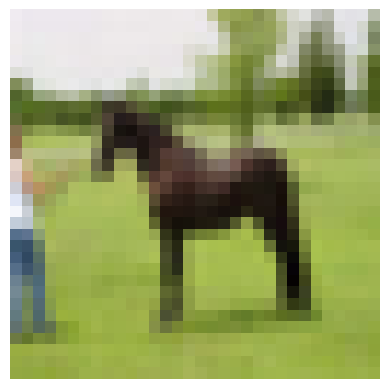

In [140]:
transform = transforms.Compose([transforms.ToTensor()])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

image, label = testset[np.random.randint(len(testset))]
image = image.to(device)

def imshow(img):
    img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

print("Image Sample:")
imshow(image)

In [141]:
image.shape

torch.Size([3, 32, 32])

In [142]:
image_batch = image.unsqueeze(0).to(device)  # Shape: (batch_size=1, channels, height, width)
batch_size, channels, height, width = image_batch.shape
image_batch.shape

torch.Size([1, 3, 32, 32])

In [143]:
in_channels = image.shape[0]
kernel_size = 5

The extracted image consists of 3 channels (R, G, B) with dimensions 4032x3024.

### 1. Depthwise Convolution


Depthwise convolution operates on each input channel separately instead of capturing patterns across channels. For each channel, it applies a single convolutional filter, and there is no mixing between the channels. This helps reduce computational complexity while emphasizing on the local spatial features in each channel. Mathematically, the depthwise convolution for the $i$-th pixel is defined as:

$$
y_i = \sum_{j \in \mathcal{L}(i)} W_{i-j} \odot X_j
$$

- $y_i$ is the output feature at position $i$.
- $X_j$ is the input feature at position $j$.
- $W_{i-j}$ is the convolutional kernel applied at position $i - j$.
- $\mathcal{L}(i)$ represents the local neighborhood around pixel $i$.
- $\odot$ denotes element-wise multiplication.

We define the `DepthwiseConvLayer` below to implement the single-layer model in the following steps:
1. Identify the Local Neighborhood $\mathcal{L}(i)$ for each position $i$.
2. For each channel, apply the DWC independently.
3. For each position $i$, compute the sum over the local neighborhood.
4. Element-wise multiply the kernel weights $W_{i-j}$ with the corresponding input features $X_j$.
5. Sum the results to obtain the output feature $y_i$.


In [144]:
class DepthwiseConvLayer(nn.Module):

    def __init__(self, in_channels, kernel_size):

        super(DepthwiseConvLayer, self).__init__()

        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.kernels = nn.Parameter(torch.randn(in_channels, kernel_size, kernel_size)) # each of the 3 channels has their own kernel size K = 3

    def forward(self, x):

        _, C, H, W = x.size()
        padding = self.kernel_size // 2
        y = torch.zeros_like(x)

        x_padded = F.pad(x, (padding, padding, padding, padding), mode='constant', value=0)

        for c in range(C):

            kernel = self.kernels[c]

            for i in range(H):

                for j in range(W):
                    
                    # get local neighborhood for position (i, j)
                    # top-left corner of the neighborhood
                    i0 = i
                    j0 = j

                    x_region = x_padded[:, c, i0:i0+self.kernel_size, j0:j0+self.kernel_size]  #(batch_size, kernel_size, kernel_size)
                    weighted_sum = (kernel * x_region).sum(dim=(1, 2))  # elemwise mult kernel weights with input feature to get the weighted sum of the local region
                    
                    y[:, c, i, j] = weighted_sum

        return y

In [145]:
depthwise_layer = DepthwiseConvLayer(in_channels, kernel_size).to(device)

with torch.no_grad():
    output = depthwise_layer(image_batch)  

output_image = output.squeeze(0)

Feature Maps after Depthwise Convolution:


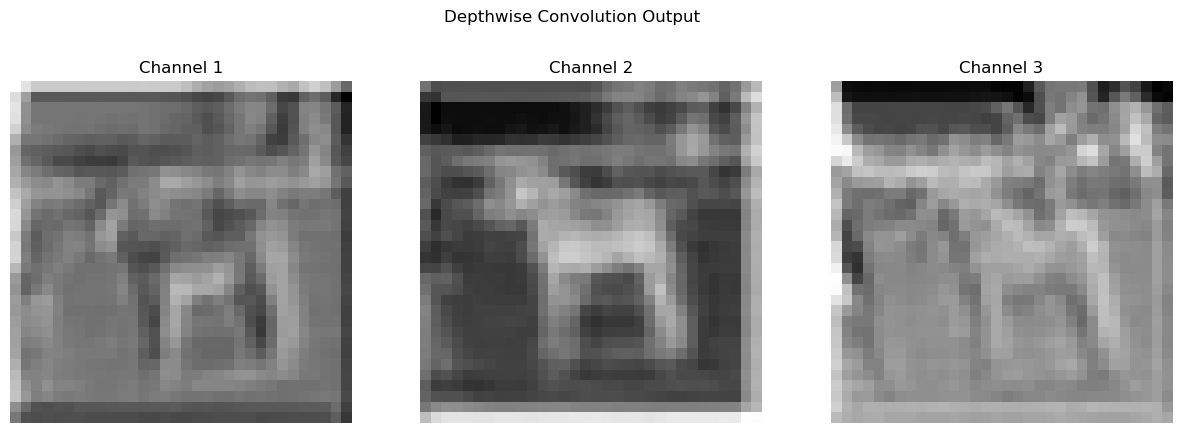

In [146]:
def visualize_feature_maps(feature_maps, title):
    num_channels = feature_maps.shape[0]
    fig, axes = plt.subplots(1, num_channels, figsize=(15, 5))
    for idx in range(num_channels):
        ax = axes[idx]
        # Normalize the feature map for better visualization
        feature_map = feature_maps[idx].cpu().numpy()
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
        ax.imshow(feature_map, cmap='gray')
        ax.axis('off')
        ax.set_title(f'Channel {idx+1}')
    plt.suptitle(title)
    plt.show()

print("Feature Maps after Depthwise Convolution:")
visualize_feature_maps(output_image, 'Depthwise Convolution Output')

- From the produced feature maps, we can observe that channel emphasizes different aspects of the input image.
- Since a single convolutional filter is applied on each of the three channels, information is being propagated locally within each channel.
- Each output pixel $y_i$ depends on a weighted sum of its neighboring pixels $X_j$ within the same channel.
- Without any cross-channel interaction, the depthwise convolution operation only captures spatial features but not cross-channel features. 
- The receptive field of each output pixel $y_i$ is dependent on the size of the kernel K. We use a $5x5$ kernel, which means $y_i$ depends on a $5x5$ neighborhood in the input space. 
- Limiting the influence allows the layer to capture local patterns such as edges or textures. Hence, the feature maps highlight edges, textures, or other local patterns, depending on the randomly initialized kernels.

### 2. Self-Attention

Self-attention allows the model to capture global dependencies by computing interactions between all pairs of positions in the input. We assume $Q$ = $K$ = $V$ = $X$, so there are no learnable parameters. 

The operation is defined as:

$$
y_i = \sum_{j \in \mathcal{G}} \frac{\exp(x_i^\top x_j)}{\sum_{k \in \mathcal{G}} \exp(x_i^\top x_k)} x_j
$$

where, 

- $y_i$: The output feature at position $i$.
- $x_i, x_j$: Input feature vectors at positions $i$ and $j$, respectively.
- $\mathcal{G}$: The set representing the global context, i.e., all positions in the input.

To implement this operation, we define the `SelfAttentionLayer` below which implements it through the following steps:

1. We compute the dot product $x_i^\top x_j$ for all pairs $(i, j)$.
2. The dot products are then exponentiated get unnormalized attention scores.
3. Unnormalized attn scores are normalized by dividing by the sum over $k$ to get attention weights.
4. Each attention weight is multiplied by the corresponding $x_j$.
5. Sum over all $j$ to get the output $y_i$ for each position $i$.

In [147]:
class SelfAttentionLayer(nn.Module):
    
    def __init__(self):    
        super(SelfAttentionLayer, self).__init__()

    def forward(self, x):
        
        B, C, H, W = x.size() 
        num_positions = H * W

        x_flat = x.view(B, C, num_positions)  
        x_transposed = x_flat.permute(0, 2, 1) 
        
        y = torch.zeros_like(x_transposed)  
        
        attention_weights_all = torch.zeros(B, num_positions, num_positions).to(x.device)
        
        for i in range(num_positions):

            x_i = x_transposed[:, i, :]  # query x_i shape: (batch_size, channels)
        
            similarity_scores = torch.sum(x_i.unsqueeze(1) * x_transposed, dim=2)  # dot products x_i^T x_j to get sim scores (batch_size, num_positions)
            exp_scores = torch.exp(similarity_scores)  
            
            # norm 
            sum_exp_scores = torch.sum(exp_scores, dim=1, keepdim=True)  
            attention_weights = exp_scores / sum_exp_scores  
            
            # attention weights * x_j 
            attention_weights_expanded = attention_weights.unsqueeze(2) 
            weighted_values = attention_weights_expanded * x_transposed 
            
            y_i = torch.sum(weighted_values, dim=1)  
            y[:, i, :] = y_i  # (batch_size, num_positions, channels)
            
            attention_weights_all[:, i, :] = attention_weights  
        
        y_output = y.permute(0, 2, 1).view(B, C, H, W)
        
        return y_output, attention_weights_all

Feature Maps after Self-Attention:


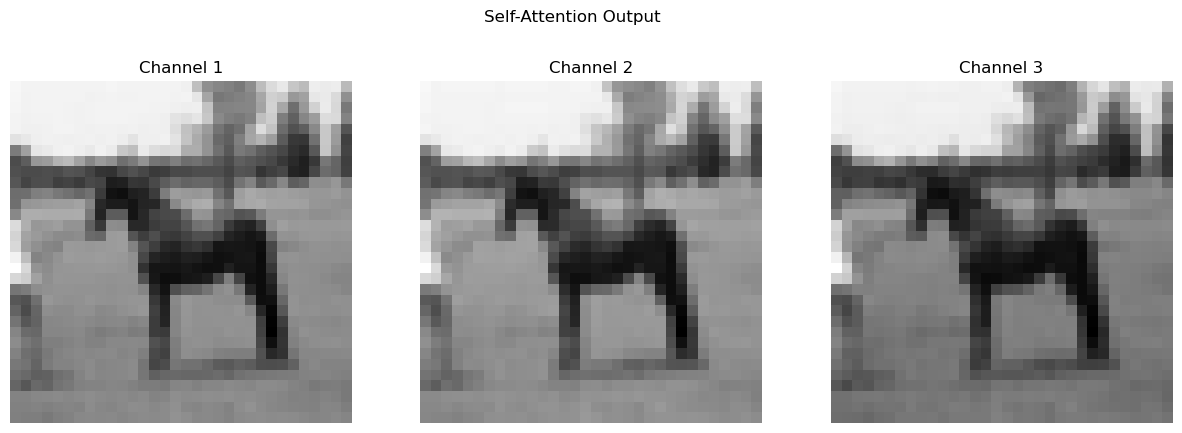

In [148]:
self_attention_layer = SelfAttentionLayer().to(device)

with torch.no_grad():
    y_output, attention_weights_all = self_attention_layer(image_batch)

output_image = y_output.squeeze(0)  

print("Feature Maps after Self-Attention:")
visualize_feature_maps(output_image, 'Self-Attention Output')


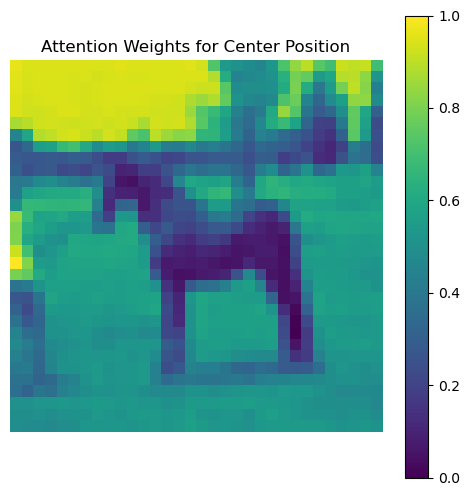

In [149]:
center_row = height // 2
center_col = width // 2
center_position = center_row * width + center_col  

attention_weights_center = attention_weights_all[0, center_position, :].view(height, width).cpu().numpy()
attention_weights_center = (attention_weights_center - attention_weights_center.min()) / (attention_weights_center.max() - attention_weights_center.min())

plt.figure(figsize=(6, 6))
plt.imshow(attention_weights_center, cmap='viridis')
plt.axis('off')
plt.title('Attention Weights for Center Position')
plt.colorbar()
plt.show()


- The self attention mechanism enables the model to consider global context by computing interactions between all pairs of positions.
- Information is being propagated globally since each output feature $y_i$ depends on all input features $x_j$ weighted by attention weights (computed based on similarity between $x_i$ and $x_j$)
- Unlike conv layers with local receptive fields, the receptive field is unlimited, covering the entire image as each output position considers information from all positions in the input space.
- Visualizing the attention weights for the center position helps us see how much the center position attends to other positions in the image. Regions that are similar to the center pixel have higher attention weights. Moreover, attention is distributed spatially across the image.
- The attention is heavily concentrated around the horse’s body and the surrounding pixels, but also spreads out to the background, suggesting the model is using the broader context to better understand the central region.Unlike the depthwise convolution, self-attention helps retain a better global understanding of the horse's position relative to the background, improving spatial coherence.

### 3. Post-Normalization Combination

The post-normalization combination integrates the self-attention mechanism with depthwise convolution by adding the convolutional weights after the attention normalization step. The operation is formulated as,

$$
y_i^{\text{post}} = \sum_{j \in \mathcal{G}} \left( \frac{\exp(x_i^\top x_j)}{\sum_{k \in \mathcal{G}} \exp(x_i^\top x_k)} + W_{i-j} \right) x_j 
$$

where

- $y_i^{\text{post}}$ = output feature vector at position $i$
- $x_i, x_j$ = input feature vectors at positions $i$ and $j$ respectively
- $\mathcal{G}$ = the global context (set of all positions in the input)
- $W_{i-j}$ = convolutional kernel weight corresponding to the relative position $i - j$
- $x_i^\top x_j$ = dot prod of feature vectors at positions $i$ and $j$

WE define the class `PostNormCombinationLayer` below to implement this formulation in the following steps:

1. Compute the attention weights $a_{ij}$ over the global context
2. Add the convolutional weights $W_{i-j}$ to the attention weights after normalization. For simplicity we average the channels to get a scalar $W_{i-j}$ 
3. Multiply the combined weights by $x_j$ and sum over all $j$ to get $y_i^{\text{post}}$.


In [150]:
class PostNormCombinationLayer(nn.Module):
    
    def __init__(self, in_channels, kernel_size):
    
        super(PostNormCombinationLayer, self).__init__()
    
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.kernels = nn.Parameter(torch.randn(in_channels, kernel_size, kernel_size))

    def forward(self, x):

        B, C, H, W = x.size()
        num_positions = H * W

        x_flat = x.view(B, C, num_positions)  
        x_transposed = x_flat.permute(0, 2, 1)
        y = torch.zeros_like(x_transposed)  

        attention_weights_all = torch.zeros(B, num_positions, num_positions).to(x.device)

        position_to_coords = {}
        index = 0

        for row in range(H):

            for col in range(W):

                position_to_coords[index] = (row, col)
                index += 1

        W_i_j = torch.zeros(num_positions, num_positions).to(x.device)

        # computing W_{i-j} by averaging over all three channels
        
        for i in range(num_positions):
        
            i_row, i_col = position_to_coords[i]
        
            for j in range(num_positions):
        
                j_row, j_col = position_to_coords[j]
                delta_row = i_row - j_row
                delta_col = i_col - j_col
        
                if abs(delta_row) <= self.padding and abs(delta_col) <= self.padding:
        
                    kernel_row = delta_row + self.padding
                    kernel_col = delta_col + self.padding
        
                    if 0 <= kernel_row < self.kernel_size and 0 <= kernel_col < self.kernel_size:

                        kernel_values = self.kernels[:, kernel_row, kernel_col]
                        W_i_j[i, j] = kernel_values.mean().item()

                else:
                    
                    W_i_j[i, j] = 0

        for i in range(num_positions):

            x_i = x_transposed[:, i, :]  
            
            similarity_scores = torch.sum(x_i.unsqueeze(1) * x_transposed, dim=2)
            exp_scores = torch.exp(similarity_scores)  
            sum_exp_scores = torch.sum(exp_scores, dim=1, keepdim=True)
            
            attention_weights = exp_scores / sum_exp_scores  
            attention_weights_all[:, i, :] = attention_weights  
            
            W_i_j_row = W_i_j[i, :].unsqueeze(0).expand(B, -1)  
            
            combined_weights = attention_weights + W_i_j_row  
            combined_weights_expanded = combined_weights.unsqueeze(2)  
            
            weighted_x_j = combined_weights_expanded * x_transposed  

            y_i = torch.sum(weighted_x_j, dim=1)
            
            y[:, i, :] = y_i  

        y_output = y.permute(0, 2, 1).view(B, C, H, W)

        return y_output, attention_weights_all

In [151]:
post_norm_layer = PostNormCombinationLayer(in_channels, kernel_size).to(device)

with torch.no_grad():
    y_output, attention_weights_all = post_norm_layer(image_batch)

output_image = y_output.squeeze(0)

Feature Maps after Post-Normalization Combination:


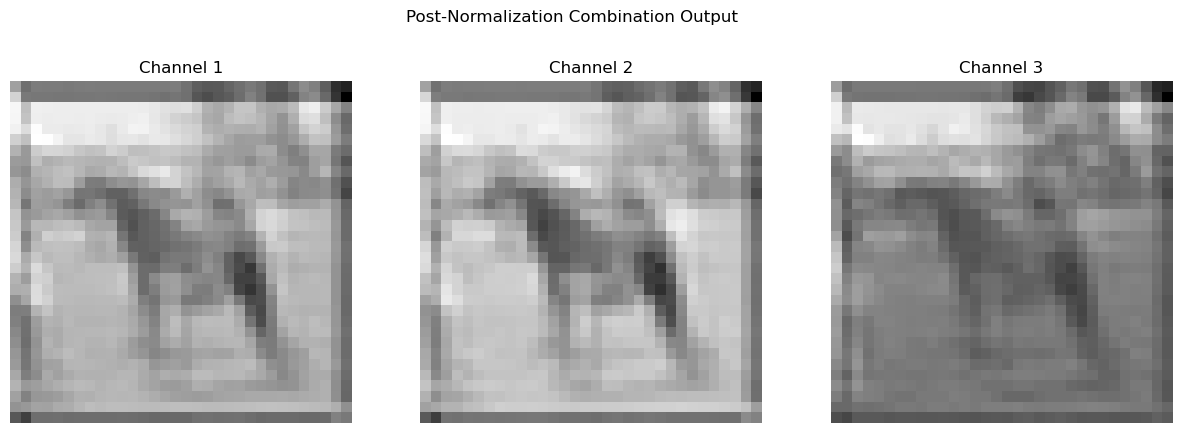

In [152]:
print("Feature Maps after Post-Normalization Combination:")
visualize_feature_maps(output_image, 'Post-Normalization Combination Output')

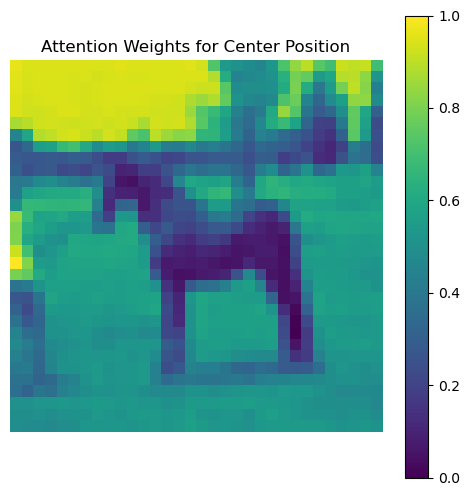

In [153]:
center_row = height // 2
center_col = width // 2
center_position = center_row * width + center_col  

attention_weights_center = attention_weights_all[0, center_position, :].view(height, width).cpu().numpy()
attention_weights_center = (attention_weights_center - attention_weights_center.min()) / (attention_weights_center.max() - attention_weights_center.min())

plt.figure(figsize=(6, 6))
plt.imshow(attention_weights_center, cmap='viridis')
plt.axis('off')
plt.title('Attention Weights for Center Position')
plt.colorbar()
plt.show()

- In this combined operation, information is propagated both locally and globally. Local propagations occurs through the convolutional weights $W_{i-j}$, which consider neighboring pixels within the kernel size. Global propagation occurs via the self-attn weights where each position $i$ attends to all other positions $j$ in the input.
- By adding the convolutional weights to the attention weights after normalization, we ensure that local features are enhanced while still capturing global dependencies.
- The receptive field remains global due to the self-attention component with the convolutional component emphasizing local neighborhoods. 
- The kernel size $F$ determines the extent of local interactions, influencing how much weight is given to nearby pixels.
- We can see that the combined operation allows for global context awareness with more pronounced local representations such as edges due to the conv.
- The attention weights visualization shows that the self-attention component still ensures that distant pixels still contribute to the output.
- Overall, the combination reinforces local patterns while capturing global representations which allows for a balanced feature extraction

### 4. Pre-Normalization Combination

We now explore the pre-normalization combination which integrates the self-attention mechanism with depthwise convolution by adding the convolutional weights before the attention normalization step.

The operation is formulated as:

$$
y_i^{\text{pre}} = \sum_{j \in \mathcal{G}} \left( \frac{\exp(x_i^\top x_j + W_{i-j})}{\sum_{k \in \mathcal{G}} \exp(x_i^\top x_k + W_{i-k})} \right) x_j 
$$

- $y_i^{\text{pre}}$ = output feature vector at $i$.
- $x_i, x_j$ = input feature vectors at $i$ and $j$.
- $\mathcal{G}$ = global context.

We define the class `PreNormCombinationLayer` below to implement this formulation in the following steps:

1. Compute the attention scores $s_{ij} = x_i^\top x_j + W_{i-j}$ over the global context
2. Apply the softmax normalization to obtain attention weights

   $$
   a_{ij} = \frac{\exp(s_{ij})}{\sum_{k \in \mathcal{G}} \exp(s_{ik})}
   $$

3. Multiply the attention weights $a_{ij}$ by $x_j$ and sum over all $j$ to get $y_i^{\text{pre}}$.

In [154]:
class PreNormCombinationLayer(nn.Module):
    
    def __init__(self, in_channels, kernel_size):
        
        super(PreNormCombinationLayer, self).__init__()
        
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.kernels = nn.Parameter(torch.randn(in_channels, kernel_size, kernel_size))

    def forward(self, x):

        B, C, H, W = x.size()
        num_positions = H * W

        x_flat = x.view(B, C, num_positions)  
        x_transposed = x_flat.permute(0, 2, 1)  
        y = torch.zeros_like(x_transposed)  

        attention_weights_all = torch.zeros(B, num_positions, num_positions).to(x.device)
        
        position_to_coords = {}
        index = 0

        for row in range(H):

            for col in range(W):

                position_to_coords[index] = (row, col)
                index += 1
        
        W_i_j = torch.zeros(num_positions, num_positions).to(x.device)
        
        for i in range(num_positions):
            
            i_row, i_col = position_to_coords[i]
            
            for j in range(num_positions):
            
                j_row, j_col = position_to_coords[j]
                delta_row = i_row - j_row
                delta_col = i_col - j_col
            
                if abs(delta_row) <= self.padding and abs(delta_col) <= self.padding:
            
                    kernel_row = delta_row + self.padding
                    kernel_col = delta_col + self.padding
                    
                    if 0 <= kernel_row < self.kernel_size and 0 <= kernel_col < self.kernel_size:
                        
                        kernel_values = self.kernels[:, kernel_row, kernel_col]
                        W_i_j[i, j] = kernel_values.mean().item()
            
                else:
            
                    W_i_j[i, j] = 0  

        for i in range(num_positions):
            
            x_i = x_transposed[:, i, :]  
            similarity_scores = torch.sum(x_i.unsqueeze(1) * x_transposed, dim=2)  
            
            W_i_j_row = W_i_j[i, :].unsqueeze(0).expand(B, -1)  
            s_ij = similarity_scores + W_i_j_row  
            
            exp_scores = torch.exp(s_ij) 
            sum_exp_scores = torch.sum(exp_scores, dim=1, keepdim=True) 
            
            attention_weights = exp_scores / sum_exp_scores 
            attention_weights_all[:, i, :] = attention_weights  
            attention_weights_expanded = attention_weights.unsqueeze(2)  
            
            weighted_x_j = attention_weights_expanded * x_transposed  
            
            y_i = torch.sum(weighted_x_j, dim=1)  
            
            y[:, i, :] = y_i  

        y_output = y.permute(0, 2, 1).view(B, C, H, W)

        return y_output, attention_weights_all


In [155]:
pre_norm_layer = PreNormCombinationLayer(in_channels, kernel_size).to(device)

with torch.no_grad():
    y_output, attention_weights_all = pre_norm_layer(image_batch)

output_image = y_output.squeeze(0)

Feature Maps after Pre-Normalization Combination:


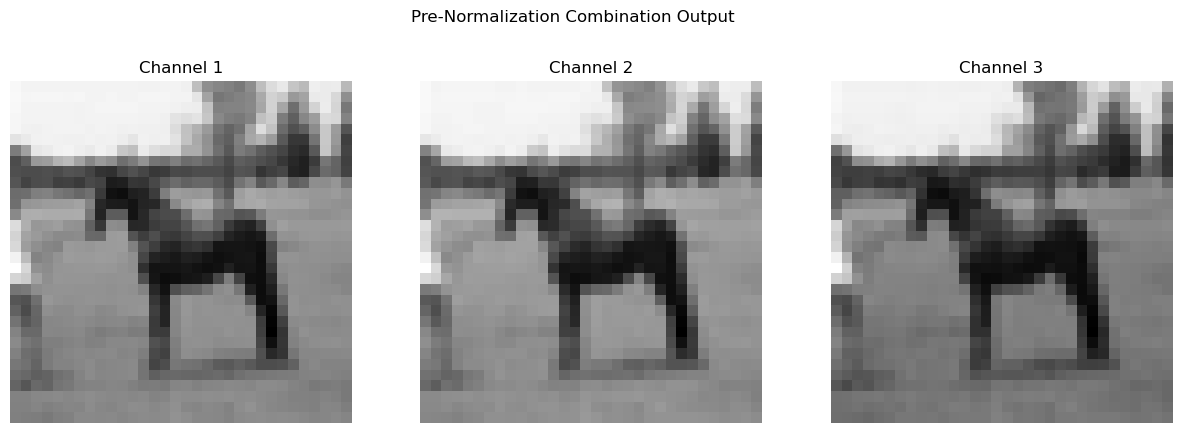

In [156]:
print("Feature Maps after Pre-Normalization Combination:")
visualize_feature_maps(output_image, 'Pre-Normalization Combination Output')


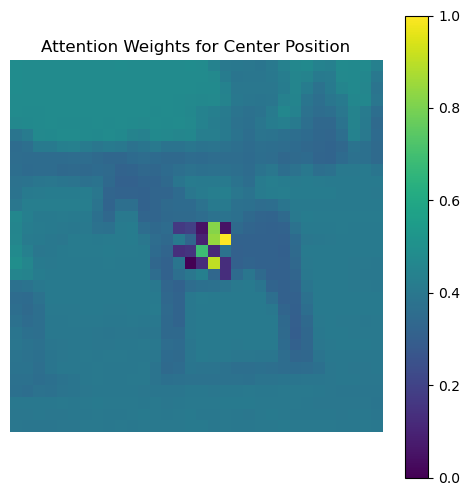

In [157]:
center_row = height // 2
center_col = width // 2
center_position = center_row * width + center_col  

attention_weights_center = attention_weights_all[0, center_position, :].view(height, width).cpu().numpy()
attention_weights_center = (attention_weights_center - attention_weights_center.min()) / (attention_weights_center.max() - attention_weights_center.min())

plt.figure(figsize=(6, 6))
plt.imshow(attention_weights_center, cmap='viridis')
plt.axis('off')
plt.title('Attention Weights for Center Position')
plt.colorbar()
plt.show()

- The receptive field is global since each position attends to all others. 
- In the pre-norm combination, the conv weights affect the attn scores before normalizaation which affects how attention is distributed across positions. By adding $W_{i-j}$ inside the exponential function, we modulate the attention scores, potentially emphasizing certain positions over others based on the convolutional weights. However, in this process, the convolutional weights can influence the attention mechanism to focus more on local neighborhoods or specific patterns, giving rise to attention bias.
- Since pre-normalization combination preserves local details better, particularly the edges and textures, due to the convolutional operation being applied before the global attention mechanism, we see sharper feature maps.
- From the visualization of the attention weights, we see a highly localized attention on the central portion of the image, mostly focusing on the core of the horse. The tight concentration of attention here indicates that the pre-normalization step amplifies local features before distributing global attention weights.Compared to the post-normalization method, this model is more focused on specific parts of the horse and less on the surrounding context, leading to a more refined representation of the key object.

### 5. Attention Modulated Convolution

Now we explore the combination of convolution and attention mechanisms within a local neighborhood defined by the convolutional kernel. This convolutional operation enhances the traditional convolution by modulating it with attention weights, allowing the model to focus on important features within the local context (receptive field).

The formulation for the operation is as follows, 

$$
Y(i) = \sum_{j \in \mathcal{L}(i)} A(i,j) \odot X(j) \odot W(i - j)
$$

where

- $Y(i)$ = output feature at position $i$.
- $X(j)$ = input feature at position $j$.
- $W(i - j)$ = convolutional kernel weights corresponding to the relative position $i - j$.
- $\mathcal{L}(i)$ = local neighborhood around position $i$ (e.g., defined by the kernel size).
- $A(i, j)$ = attention weight between positions $i$ and $j$, computed as:

  $$
  A(i, j) = \frac{\exp(\text{score}(Q(i) \cdot K(j)))}{\sum_{k \in \mathcal{L}(i)} \exp(\text{score}(Q(i) \cdot K(k)))} 
  $$

  - $Q(i)$ = query vector at position $i$, derived from the input feature $X(i)$.
  - $K(j)$ = key vector at position $j$, derived from the input feature $X(j)$.

In [158]:
class AttentionModulatedConvLayer(nn.Module):
    
    def __init__(self, in_channels, kernel_size):
    
        super(AttentionModulatedConvLayer, self).__init__()
    
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.query_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.kernels = nn.Parameter(torch.randn(in_channels, kernel_size, kernel_size))

    def forward(self, x):
        
        B, C, H, W = x.size()
        padding = self.padding

        Q = self.query_conv(x)
        K = self.key_conv(x)

        y = torch.zeros_like(x)

        x_padded = F.pad(x, (padding, padding, padding, padding), mode='constant', value=0)
        K_padded = F.pad(K, (padding, padding, padding, padding), mode='constant', value=0)

        center_row = H // 2
        center_col = W // 2
        attention_weights_center = None

        for i in range(H):
        
            for j in range(W):
        
                i0 = i
                j0 = j

                K_neighborhood = K_padded[:, :, i0:i0+self.kernel_size, j0:j0+self.kernel_size]
                X_neighborhood = x_padded[:, :, i0:i0+self.kernel_size, j0:j0+self.kernel_size]

                K_j = K_neighborhood.reshape(B, C, -1)
                X_j = X_neighborhood.reshape(B, C, -1)

                Q_i = Q[:, :, i, j].unsqueeze(2)

                similarity_scores = torch.sum(Q_i * K_j, dim=1)

                attention_scores = F.softmax(similarity_scores, dim=1)

                kernels = self.kernels.unsqueeze(0).expand(B, -1, -1, -1)
                W_i_j = kernels.reshape(B, C, -1)

                Xj_Wij = X_j * W_i_j

                attention_weights_expanded = attention_scores.unsqueeze(1)
                modulated_values = Xj_Wij * attention_weights_expanded

                y_i = torch.sum(modulated_values, dim=2)

                y[:, :, i, j] = y_i

                if i == center_row and j == center_col:
                    attention_weights_center = attention_scores.clone().detach()

        return y, attention_weights_center


Feature Maps after Attention Modulated Convolution:


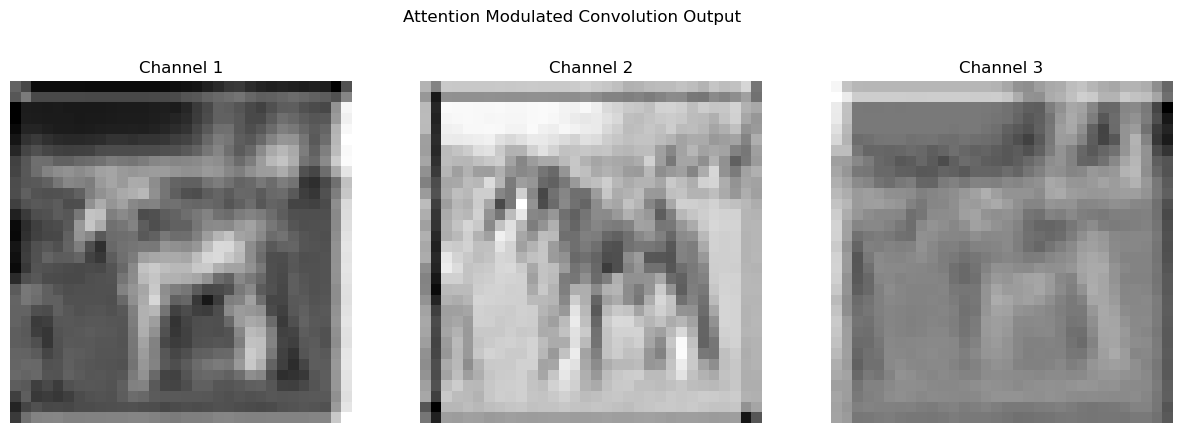

In [159]:
attention_mod_conv_layer = AttentionModulatedConvLayer(in_channels, kernel_size).to(device)

with torch.no_grad():
    output, attention_weights_center = attention_mod_conv_layer(image_batch)

output_image = output.squeeze(0)

print("Feature Maps after Attention Modulated Convolution:")
visualize_feature_maps(output_image, 'Attention Modulated Convolution Output')

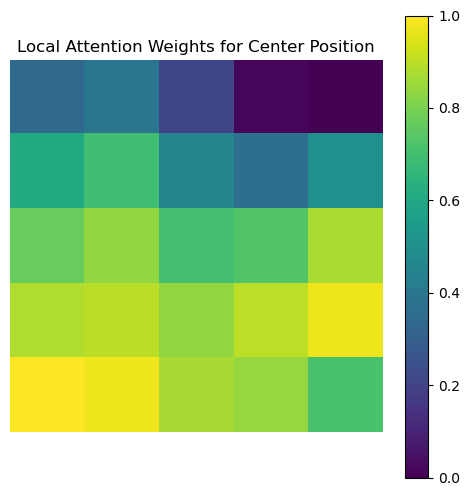

In [160]:
if attention_weights_center is not None:

    attention_weights_center = attention_weights_center.squeeze(0)
    kernel_size = attention_mod_conv_layer.kernel_size
    attention_weights_center = attention_weights_center.view(kernel_size, kernel_size).cpu().numpy()

    attention_weights_center = (attention_weights_center - attention_weights_center.min()) / (attention_weights_center.max() - attention_weights_center.min())

    plt.figure(figsize=(6, 6))
    plt.imshow(attention_weights_center, cmap='viridis')
    plt.axis('off')
    plt.title('Local Attention Weights for Center Position')
    plt.colorbar()
    plt.show()
else:
    print("Attention weights for the center position were not captured.")

- Information is propagated within the local neighbourhood $L_i$ of each pixel $i$. The attention mechanism allows the model to focus on important features within this neighborhood.
- The receptive field for each output pixel $Y(i)$ is defined by the kernel size $F$ of the convolution, focusing on a local neighborhood around $i$. By integrating attention weights into the convolution operation, the model gains the ability to dynamically adjust the importance of features within this local receptive field.
- The choice of kernel size affects the receptive field and the model's ability to capture patterns. A larger kernel increases the receptive field but also the computational cost

### 6. Convolution Modulated Attention

This operation combines depthwise conv and attention mechanisms by applying a depthwise convolution to the input, using the result to compute attention weights via softmax, and then modulating the values by these attention weights.

The mathematical formulation is, 

$$
\text{Attention}(X) = \text{Softmax}(\text{DWConv}_{F \times F}(X, W)) \odot V 
$$

where 

- $X$ = input feature map
- $\text{DWConv}_{F \times F}(X, W)$ = depthwise convolution of $X$ with kernel $W$ of size $F \times F$
- **Softmax** = activation function applied to the convolution output to obtain attn weights
- $V$ = value tensor
- $\odot$ = element-wise multiplication

In [161]:
class ConvolutionModulatedAttentionLayer(nn.Module):
    
    def __init__(self, in_channels, kernel_size):
    
        super(ConvolutionModulatedAttentionLayer, self).__init__()
    
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.depthwise_conv = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, padding=self.padding, groups=in_channels)
        self.value_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):

        B, C, H, W = x.size()

        attention_scores = self.depthwise_conv(x)
        attention_scores_flat = attention_scores.view(B, C, -1)
        attention_weights = F.softmax(attention_scores_flat, dim=2)
        attention_weights = attention_weights.view(B, C, H, W)

        V = self.value_conv(x)
        output = attention_weights * V

        return output, attention_weights


In [162]:
conv_mod_attention_layer = ConvolutionModulatedAttentionLayer(in_channels, kernel_size).to(device)

with torch.no_grad():
    output, attention_weights = conv_mod_attention_layer(image_batch)

output_image = output.squeeze(0)

Feature Maps after Convolution Modulated Attention:


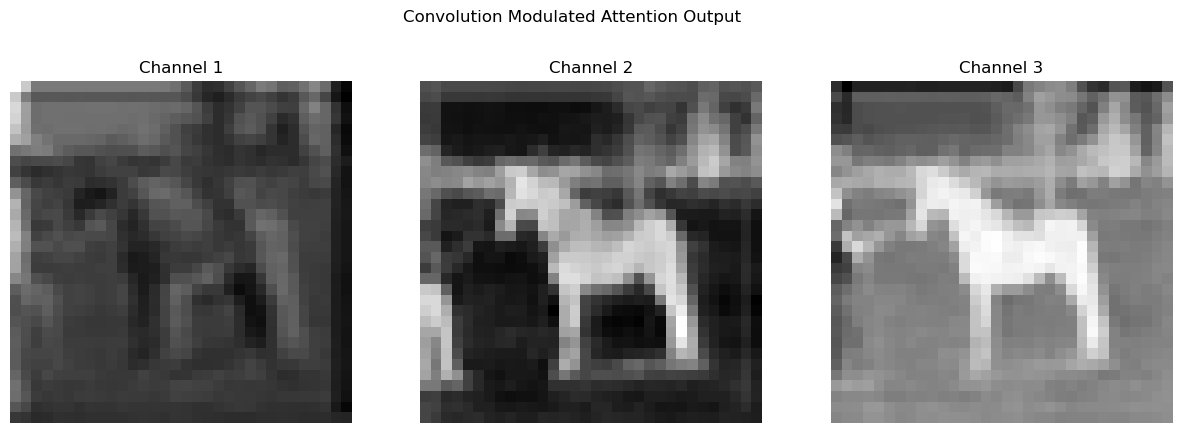

In [163]:
print("Feature Maps after Convolution Modulated Attention:")
visualize_feature_maps(output_image, 'Convolution Modulated Attention Output')

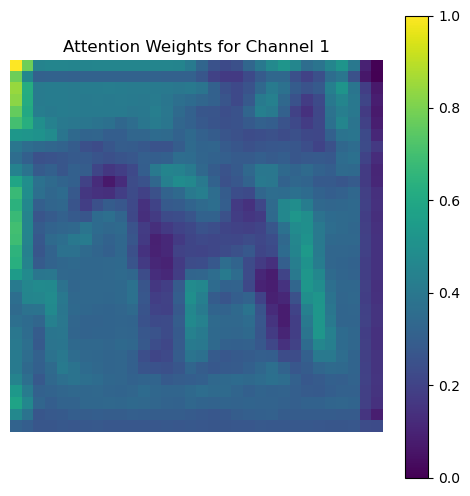

In [164]:
attention_weights_channel = attention_weights[0, 0, :, :].cpu().numpy()

attention_weights_channel = (attention_weights_channel - attention_weights_channel.min()) / (attention_weights_channel.max() - attention_weights_channel.min())

plt.figure(figsize=(6, 6))
plt.imshow(attention_weights_channel, cmap='viridis')
plt.axis('off')
plt.title('Attention Weights for Channel 1')
plt.colorbar()
plt.show()

- The operation emphasizes local feature extraction while still leveraging an attention mechanism to improve feature representation.
- The output feature maps show the result of modulating the input with the attention weights. Areas with higher attention are enhanced, while less important regions are suppressed.
- The attention weights maps reveal which spatial locations within each channel are considered more important. Bright areas indicate higher attention weights.
- Information propagation: The DWConv captures local spatial features within each of the three channels independently. Each output at position $(i,j)$ depends on the input values within the kernel centered at $(i,j)$. THen, a softmax function is applied over all spatial dimensions for each channel, producing attention weights that highlight important spatial locations within each channel.Finally, the input values X are modulated by the attention weights, emphasizing or suppressing features based on their importance.
- The receptive field is Determined by the kernel size $F$ of the depthwise convolution. For example, for a kernel size of $3x3$, the receptive field is limited to immediate neighbors.
- Multiplying the attention weights with the input values enhances important features while suppressing less relevant ones.